
*Technical University of Munich<br>
Professorship of Environmental Sensing and Modeling<br><br>*
**Author:**  Daniel Kühbacher & Ali Ahmad Khan<br>
**Date:**  29.11.2023

--- 

# Combine preprocessed datasets

This file is to construct a final counting data product that combines different counting data sources, cleanes and aggregates the data and finally adds further information from different sources. The final product can be used in the emission generator pipeline to calculate actual emissions.

**Required steps**
- import counting data, the traffic model and the calendar
- filter for metric "volume"
- aggregate count data by road links (A single road link could have several detectors on different lanes. These need to be aggregated)
- add road type information from the traffic model and day type infromation from the calendar
- Filter for valid rows: check consistency between sum of hourly values and the daily sum and only accept data with daily value > 1; drop ivalid rows
- Check for the consistency with the visum model -> add flag "valid" if consistent
- Flag as "incomplete" if there is no data from 2019-2022
- Store as parquet file

In [1]:
import sys
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from math import sqrt

# import custom modules
sys.path.append('../../utils')
from excel_calendar import Calendar
import data_paths

### Import and prepare datasets
- preprocessed BASt traffic counting data (only traffic volume)
- preprocessed LHM traffic counting data (traffic volume and speed)
- traffic model
- calendar 

In [2]:
# define file paths
mst_file_path = data_paths.MST_COUNTING_PATH + 'preprocessed_lhm_counting_data.parquet'
bast_file_path = data_paths.BAST_COUNTING_PATH + 'preprocessed_bast_counting_data.parquet'
visum_file_path = data_paths.VISUM_FOLDER_PATH + 'visum_links.gpkg'

# import and concatenate bast and mst counting data
counting_data = pd.concat([pd.read_parquet(mst_file_path), 
                           pd.read_parquet(bast_file_path)], axis = 0)

# import visum links data
visum_links = gpd.read_file(visum_file_path)

# initialize calendar object
cal_obj = Calendar()

print(f'Number of imported rows in the counting data: {len(counting_data)}')

Number of imported rows in the counting data: 3258862


### Prepare traffic volume dataset
First we will filter the data for traffic volume counts and aggregate the single detector values. Then further information is added from the visum model and the calendar.</br>
Rows with none road types will be dropped since they are not assigned to any road link in the visum model.

In [3]:
min_date = '2019-01-01'
max_date = '2022-12-31'

# reduce to 2019 - 2022 data
counting_data = counting_data[counting_data['date'].between(min_date,max_date)]

# aggregate counts for each road_link_id and reduce to volume dataset
volume  = counting_data.groupby(['metric','road_link_id',
                                 'vehicle_class','date']).sum(numeric_only = True).loc['volume']
volume = volume.drop(['detector_id'], axis = 1)
volume = volume.reset_index()

# add road type information
road_types = visum_links.set_index('road_link_id')['road_type'].to_dict()
volume.insert(4,'road_type' , volume['road_link_id'].map(road_types))
# drop rows with road_type = "none"
volume = volume[volume['road_type'] != 'none']

# add day type information
dates = volume['date'].unique()
day_types = {date:cal_obj.get_day_type_combined(date) for date in dates}
volume.insert(5, 'day_type', volume['date'].map(day_types))

# drop rows with NaN values
volume = volume.dropna()

print(f'Number of rows in the volume dataset: {len(volume)}\n')
print('Number of detectors on each road type:')
print(pd.Series([road_types[i] for i in volume['road_link_id'].unique()]).value_counts())
volume.head()

Number of rows in the volume dataset: 634558

Number of detectors on each road type:
Local/Collector               49
Motorway-Nat                  34
TrunkRoad/Primary-City        16
TrunkRoad/Primary-National    11
Access-residential             1
Name: count, dtype: int64


,road_link_id,vehicle_class,date,daily_value,road_type,day_type,0,1,2,3,...,15,16,17,18,19,20,21,22,23,24
8594,38.0,BUS,2019-01-02,3.0,TrunkRoad/Primary-City,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
8595,38.0,BUS,2019-01-03,117.0,TrunkRoad/Primary-City,2,5.0,2.0,0.0,1.0,...,4.0,2.0,3.0,10.0,4.0,5.0,3.0,2.0,2.0,0.0
8596,38.0,BUS,2019-01-04,100.0,TrunkRoad/Primary-City,2,8.0,1.0,0.0,0.0,...,5.0,2.0,8.0,6.0,4.0,5.0,0.0,3.0,5.0,0.0
8597,38.0,BUS,2019-01-05,114.0,TrunkRoad/Primary-City,3,7.0,3.0,1.0,1.0,...,3.0,2.0,4.0,12.0,2.0,8.0,3.0,3.0,4.0,0.0
8598,38.0,BUS,2019-01-06,84.0,TrunkRoad/Primary-City,4,1.0,2.0,0.0,0.0,...,7.0,4.0,3.0,3.0,5.0,2.0,4.0,2.0,3.0,0.0


### Filter for valid rows

In [4]:
# sum of all hour values of the day needs to be consistent with the sum of the day -> error_bound e=2%
e = 0.05

# Filter rows based on the condition
volume_processed = volume[
    volume.iloc[:, 6:].sum(axis=1).between(
        volume['daily_value'] * (1 - e),
        volume['daily_value'] * (1 + e)
    )
].copy()

# drop rows with daily_volume <1
volume_processed = volume_processed[volume_processed['daily_value'] > 10]

print(f'Remaining number of rows: {len(volume_processed)}')
print(pd.Series([road_types[i] for i in volume_processed['road_link_id'].unique()]).value_counts())

Remaining number of rows: 535065
Local/Collector               43
Motorway-Nat                  33
TrunkRoad/Primary-City        16
TrunkRoad/Primary-National    10
Access-residential             1
Name: count, dtype: int64


### Check for consistency with VISUM model

For 2019 data we can check if the average daily count for weekdays outside the vacation time agrees with the visum model. The SQV (scalable quality value) is used with an f-factor of 10000. This sqv value indicates how well the modeled and observed data agrees while >0.8 is a good fit and >0.6 an acceptable fit. To avoid big influence by outliers, the inter-quantile range mean was selected to aggregate the counting data. 

In [5]:
def iqr_mean(input, iqr_range = (5,95)):
    lower_bound = np.percentile(input, iqr_range[0])
    upper_bound = np.percentile(input, iqr_range[1])
    return np.mean(input[(input >= lower_bound) & (input <= upper_bound)])

def calc_sqv(Observed, Model, f=10000):
    # f = 10000 is the recommended factor for daily volumes 
    return 1/(1 + sqrt(pow( Model - Observed, 2) / (f * Observed)))

In [6]:
cnt_2019 = volume_processed[(volume_processed['date'].between('2019-01-01','2019-12-31')) &
                            (volume_processed['day_type'] == 0)]
mean_cnt_2019 = cnt_2019.groupby(['road_link_id', 'vehicle_class'])['daily_value'].apply(iqr_mean).reset_index()
mean_cnt_2019 = mean_cnt_2019.pivot(columns = 'vehicle_class', index = 'road_link_id')

#aggregate dtv for each road link of the visum model
visum_grp = visum_links.groupby('road_link_id')[['dtv_SUM','dtv_PC','dtv_LCV', 'dtv_HGV']].sum()

visum_validation = pd.concat([visum_grp, mean_cnt_2019], axis =1).dropna()

# calculate sqv value for each vehicle class
for vehicle_class in ['SUM', 'PC', 'LCV', 'HGV']:
    visum_validation['sqv_' + vehicle_class] = visum_validation.apply(
        lambda row: calc_sqv(row[('daily_value' , vehicle_class)], row['dtv_' + vehicle_class]), axis = 1
        )

In [7]:
# add valid road information to dict
sqv_threshold = 0.6

valid_roads = {key:False for key in volume_processed['road_link_id'].unique()}
visum_validation['valid'] = visum_validation['sqv_SUM'] > sqv_threshold
valid_roads.update(visum_validation['valid'].to_dict())
volume_processed.insert(4,'valid' , volume_processed['road_link_id'].map(valid_roads))

Text(0.5, 0.98, 'VISUM vs. Counting Data')

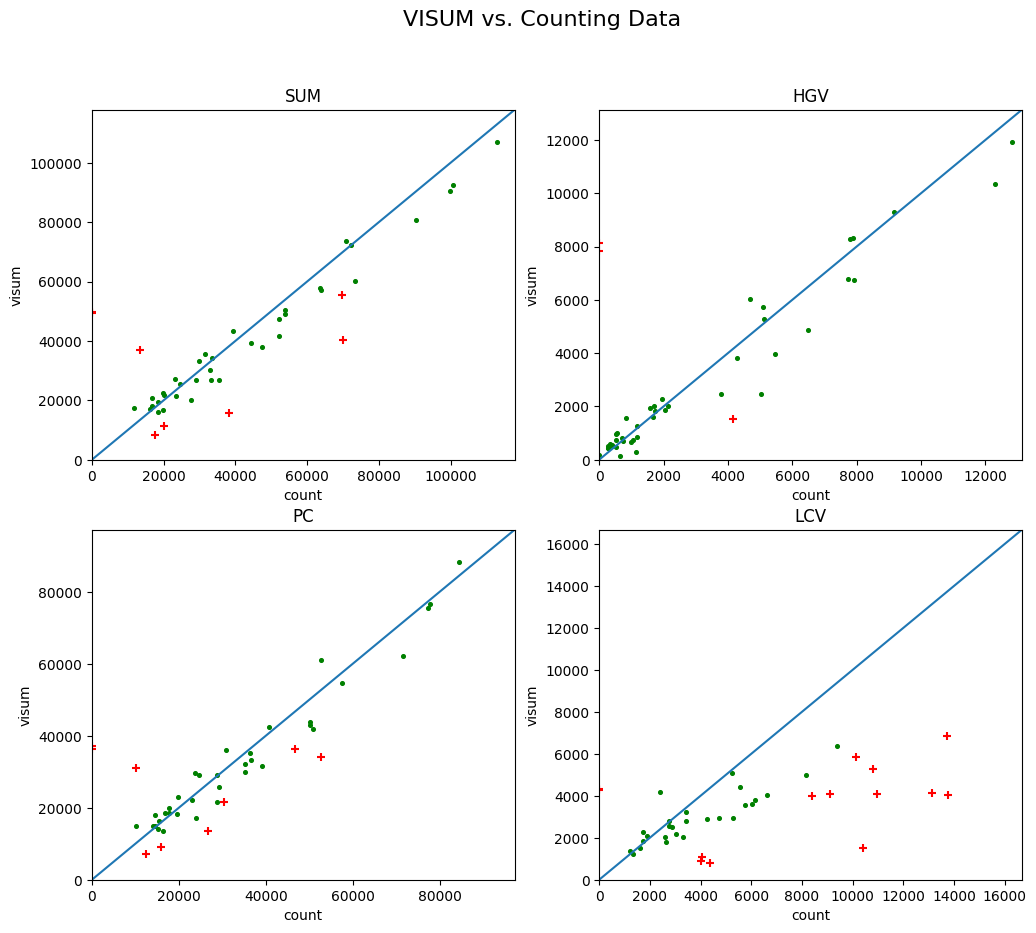

In [8]:
f = plt.figure(figsize=(12, 10))

def plot_sqv(visum, vehicle_class, pos, sqv_threshold = 0.65, fig = f):
    
    axarr = f.add_subplot(2,2,pos) # here is where you add the subplot to f
    visum['valid'] = visum['sqv_' + vehicle_class] > sqv_threshold

    axarr.scatter(x = visum[visum['valid']]['dtv_' + vehicle_class],
                y = visum[visum['valid']][('daily_value' , vehicle_class)],
                marker = 'o', label = 'valid counts', color = 'green', s = 7)
    
    axarr.scatter(x = visum[~visum['valid']]['dtv_' + vehicle_class],
                y = visum[~visum['valid']][('daily_value' , vehicle_class)], 
                marker = '+', label = 'ivalid counts', color = 'red')
    
    axarr.set_xlabel('count')
    axarr.set_ylabel('visum')
    
    axarr.set_xlim(0,visum[visum['valid']][('daily_value' , vehicle_class)].max()*1.1)
    axarr.set_ylim(0,visum[visum['valid']][('daily_value' , vehicle_class)].max()*1.1)
    
    axarr.axline((0,0),(1,1))
    axarr.set_title(vehicle_class)
    return f

f = plot_sqv(visum_validation, 'SUM', 1, fig=f)
f = plot_sqv(visum_validation, 'HGV', 2,  fig=f)
f = plot_sqv(visum_validation, 'PC', 3,  fig=f)
f = plot_sqv(visum_validation, 'LCV', 4,  fig=f)

f.suptitle('VISUM vs. Counting Data', fontsize=16)

### Flag incomplete timeseries

In [9]:
time_start = '2019-01-01'
time_end = '2022-12-31'
threshold = 0.8 #80% of days need to be included 

# find counting stations that cover
df = volume_processed[(volume_processed['vehicle_class'] == 'SUM') &
                (volume_processed['date'].between(time_start, time_end))]

df = df.groupby('road_link_id')['daily_value'].count()
complete = df[df > threshold * df.max()]
volume_processed.insert(5, 'complete', volume_processed['road_link_id'].isin(complete.index))


print(f'Number of rows of complete timeseries: {len(volume_processed[volume_processed["complete"]])}')
print(pd.Series([road_types[i] for i in volume_processed[volume_processed["complete"]]["road_link_id"].unique()]).value_counts())

Number of rows of complete timeseries: 334566
Local/Collector               16
Motorway-Nat                  13
TrunkRoad/Primary-City         8
TrunkRoad/Primary-National     6
Access-residential             1
Name: count, dtype: int64


## Store as Parquet File

In [10]:
# path to mst counting data
data_path = data_paths.COUNTING_PATH

# Store the dataframe as a parquet file
volume_processed.to_parquet(data_path+'counting_data_combined.parquet', index=False)